In [1]:
import gymnasium as gym
import cookiedisaster
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, n_features, n_actions, critic_lr, actor_lr):
        super().__init__()

        critic_layers = [
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)  # estimate action logits (will be fed into a softmax later)
        ]

        # actor and critic networks
        self.critic = nn.Sequential(*critic_layers)
        self.actor = nn.Sequential(*actor_layers)

        # optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x):
        x = torch.Tensor(x)
        state_values = self.critic(x)
        action_logits_vec = self.actor(x)
        return state_values, action_logits_vec

    def select_action(self, state):
        state_values, action_logits = self.forward(state)
        action_pd = torch.distributions.Categorical(logits=action_logits)  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return actions, action_log_probs, state_values, entropy

    def get_losses(self, rewards, action_log_probs, value_preds, entropy, gamma, lam, ent_coef):
        T = len(rewards)
        advantages = torch.zeros(T)

        gae = 0
        for t in reversed(range(T - 1)):
            td_error = (rewards[t] + gamma * value_preds[t + 1] - value_preds[t])
            gae = td_error + gamma * lam * gae
            advantages[t] = gae

        critic_loss = advantages.pow(2).mean()
        actor_loss = (-(advantages.detach() * action_log_probs).mean() - ent_coef * entropy)

        return critic_loss, actor_loss

    def update_parameters(self, critic_loss, actor_loss):
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [3]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [4]:
env = gym.make('cookiedisaster/GridWorld-v0', render_mode="rgb_array")

In [5]:
env.reset()
env.step(0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

({'agent': {'pos': 3.8, 'vel': -1.0},
  'cookie': {'pos': 0.10111663773625759, 'time': 5}},
 0,
 False,
 False,
 {'distance': 3.698883362263742, 'steps': 1})

In [6]:
# environment hyperparams
num_episodes = 100
num_steps = 1000

# agent hyperparams
gamma = 1.0
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.1  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005

n_observations = 5
n_actions = 3

agent = ActorCritic(n_observations, n_actions, critic_lr, actor_lr)

In [7]:
critic_losses = []
actor_losses = []
entropies = []
cumulative_rewards = []

# use tqdm to get a progress bar for training
for episode in range(1, num_episodes + 1):
    ep_value_preds = torch.zeros(num_steps)
    ep_rewards = torch.zeros(num_steps)
    ep_action_log_probs = torch.zeros(num_steps)
    total_rewards = 0

    # at the start of training reset env to get an initial state
    obs, info = env.reset()
    state = get_features(obs, info)

    for step in range(1, num_steps + 1):
        # select an action using state as input for the agent
        action, action_log_probs, state_value_preds, entropy = agent.select_action(state)

        # perform the action to get next state and reward
        next_obs, rewards, _, _, next_info = env.step(action.item())
        state = get_features(next_obs, next_info)

        ep_value_preds[step - 1] = torch.squeeze(state_value_preds)
        ep_rewards[step - 1] = torch.tensor(rewards)
        ep_action_log_probs[step - 1] = action_log_probs

        total_rewards += rewards

        print(f"\rEpisode: {episode}/{num_episodes}   Step: {step}/{num_steps}   Reward: {total_rewards:.3f}", end="")

    cumulative_rewards.append(total_rewards)

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(ep_rewards, ep_action_log_probs, ep_value_preds, entropy, gamma,
                                               lam, ent_coef)

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.item())
    actor_losses.append(actor_loss.item())
    entropies.append(entropy.item())

Episode: 100/100   Step: 1000/1000   Reward: 60.079

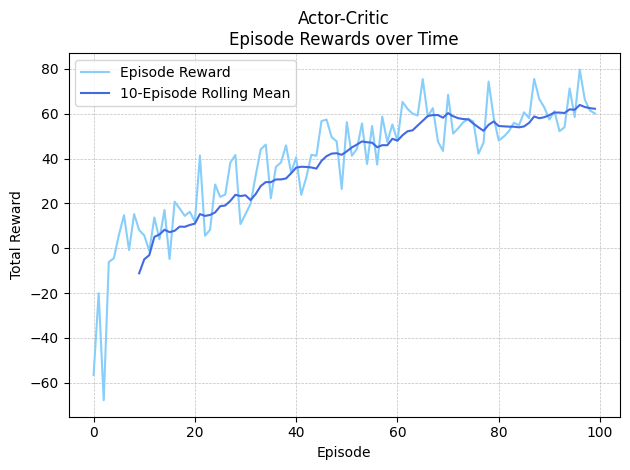

In [8]:
plt.plot(cumulative_rewards, color="lightskyblue", label="Episode Reward")
plt.plot(pd.Series(cumulative_rewards).rolling(10).mean(), color="royalblue", label="10-Episode Rolling Mean")
plt.title("Actor-Critic\nEpisode Rewards over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(color="silver", linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()